## Sample Embedding Comparison

Embeddings
* Mean approximation to EMD
* PhEMD
* L1 over clusters
* TreeEMD
* Controlled TreeEMD
* Trellis
* Controlled Trellis


### Preliminaries

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

from MultiscaleEMD import MetricTree
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import phate
import scprep
import seaborn as sns
import sklearn

data_path = "/home/mila/a/alexander.tong/scratch/"
# !ls -lah $data_path
file_name = "Metadata_final"
version = "v1"
FIG_PATH = f"figures/{version}/"
EMBED_PATH = f"{FIG_PATH}/embeddings"
os.makedirs(FIG_PATH, exist_ok=True)
os.makedirs(EMBED_PATH, exist_ok=True)

In [2]:
data = pd.read_pickle(f"{data_path}/Final_PDOs_small.pkl")
metadata = pd.read_pickle(f"{data_path}/Final_metadata_small.pkl")

In [3]:
meta = metadata.groupby("Full_names").first().drop(columns=["kmeans_10_clusters"])

In [4]:
# Define useful functions
patients = {
    "11": "#da70d6",
    "21": "#9acd32",
    "23": "#cd5c5c",
    "27": "#7d0f0f",
    "75": "#808000",
    "99": "#add8e6",
    "109": "#3b65a8",
    "141": "#663399",
    "216": "#8b008b",
    "5": "#d42f81",
}
patients_type = {
    "11": "#feb326",
    "21": "#e84d8a",
    "23": "#7f58af",
    "27": "#7f58af",
    "75": "#e84d8a",
    "99": "#64c5eb",
    "109": "#64c5eb",
    "141": "#feb326",
    "216": "#feb326",
    "5": "#feb326",
}
treatment_c = {
    "DMSO": "red",
    "H2O": "blue",
    "AH": "lightgreen",
    "S": "silver",
    "VS": "silver",
    "L": "silver",
    "F": "silver",
    "C": "silver",
    "CS": "silver",
    "CSF": "silver",
    "SF": "silver",
    "V": "silver",
    "CF": "silver",
    "O": "silver",
}
culture = {"PDO": "#008C26", "PDOF": "#FF7F7F", "F": "blue"}
culture_edge = {"PDO": "white", "PDOF": "black", "F": "blue"}
treatment = {
    "DMSO": "#000000",
    "H2O": "#000000",
    "AH": "#000000",
    "S": "#0433FF",
    "VS": "#011993",
    "L": "#F2AE40",
    "F": "#942193",
    "C": "#B7933A",
    "CS": "#005493",
    "CSF": "#0096FF",
    "SF": "#7A81FF",
    "V": "#FFD479",
    "CF": "#941751",
    "O": "#38774F",
}
concentration_color = {
    "0": "#6D18F4",
    "1": "#63CFDE",
    "2": "#95FAC2",
    "3": "#D8D988",
    "4": "#ED7548",
    "5": "#EA3D29",
}
concentration = {"0": 50, "1": 100, "2": 150, "3": 200, "4": 250, "5": 300}
concentration_big = {"0": 60, "1": 100, "2": 220, "3": 340, "4": 460, "5": 540}
replicate = {
    "A": "silver",
    "B": "silver",
    "C": "silver",
    "AA": "red",
    "BB": "red",
    "CC": "red",
}


def save_and_make_plot(embedding, save_name, fig_path=None):
    np.save(f"{EMBED_PATH}/{save_name}", embedding)
    if fig_path is None:
        fig_path = FIG_PATH
    plots = [
        ["Patient", patients_type],
        ["Concentration", concentration_color],
        ["Culture", culture],
    ]
    for col, mapper in plots:
        fig, ax = plt.subplots(1, figsize=(15, 10))
        plt.tick_params(
            left=False, right=False, labelleft=False, labelbottom=False, bottom=False
        )
        plt.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=meta[col].map(mapper),
            s=meta["Concentration"].map(concentration_big),
            alpha=0.75,
        )
        plt.axis("off")
        plt.savefig(f"{fig_path}/{save_name}_{col}.svg", transparent=True)

In [5]:
def normalize_embedding_to_control(embed):
    index = pd.MultiIndex.from_frame(
        meta.reset_index().loc[
            :,
            ["Patient", "Culture", "Concentration", "Plate", "Full_names"],
        ]
    )
    indexed_run = pd.DataFrame(embed, index=index)
    control_run = (
        indexed_run.xs(("0"), level=["Concentration"])
        .groupby(["Patient", "Culture", "Plate"])
        .mean()
    )
    diff = indexed_run - control_run
    diff = pd.DataFrame(index=index).join(diff)
    diff.index = diff.index.droplevel(["Patient", "Culture", "Concentration", "Plate"])
    return diff

### Mean Euclidean Embedding

In [6]:
embed_name = "mean_euclidean"
data["Full_names"] = metadata["Full_names"]
means = data.groupby("Full_names").mean()
del data["Full_names"]

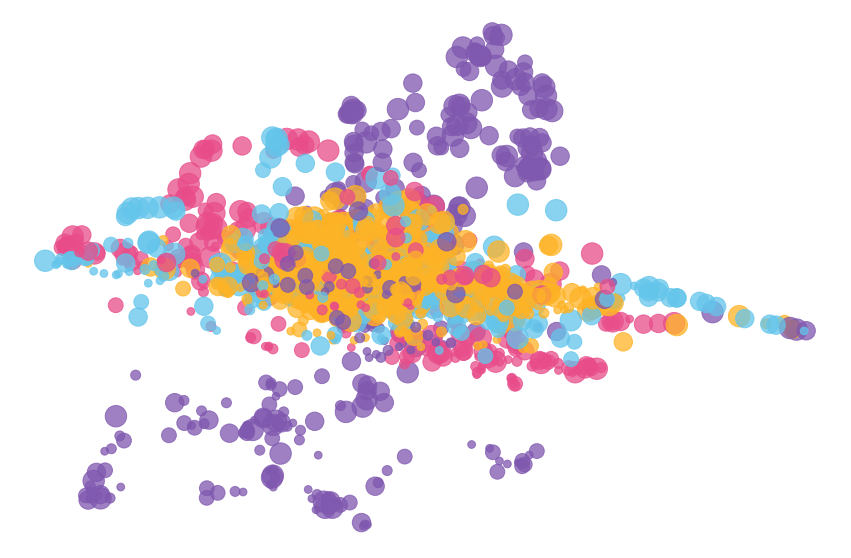

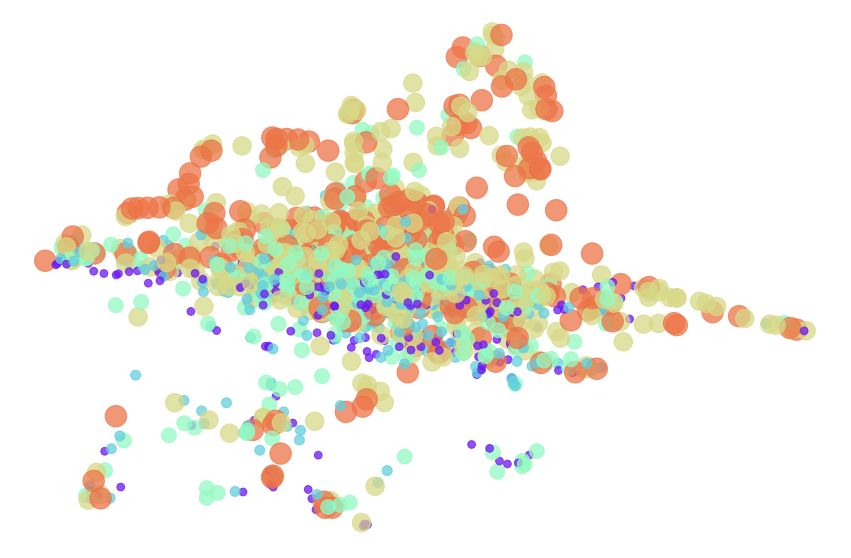

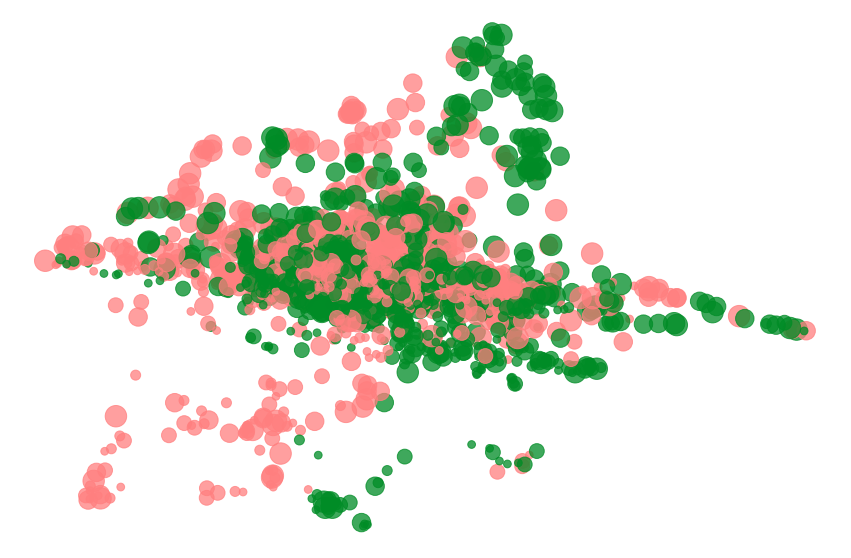

In [7]:
phate_op = phate.PHATE(
    random_state=42,
    n_jobs=-1,
    knn_dist="euclidean",
    n_pca=None,
    verbose=False,
)
phate_coords = phate_op.fit_transform(means)
save_and_make_plot(phate_coords, embed_name)

### L1 over clusters

In [8]:
embed_name = "cluster_l1"
data["kmeans_10_clusters"] = metadata["kmeans_10_clusters"]
cluster_means = data.groupby("kmeans_10_clusters").mean()
del data["kmeans_10_clusters"]

cluster_counts = (
    (
        metadata[["Full_names", "kmeans_10_clusters", "Batch"]]
        .groupby(["Full_names", "kmeans_10_clusters"])
        .count()
    )
    .reset_index()
    .pivot(index="Full_names", columns="kmeans_10_clusters", values="Batch")
    .fillna(0)
)
cluster_dists = cluster_counts.div(cluster_counts.sum(axis=1), axis=0)

/home/mila/a/alexander.tong/.conda/envs/pdo_screen/lib/python3.9/site-packages/graphtools/graphs.py:280: RuntimeWarning: Detected zero distance between samples 63 and 643, 63 and 692, 164 and 696, 643 and 692, 686 and 874. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


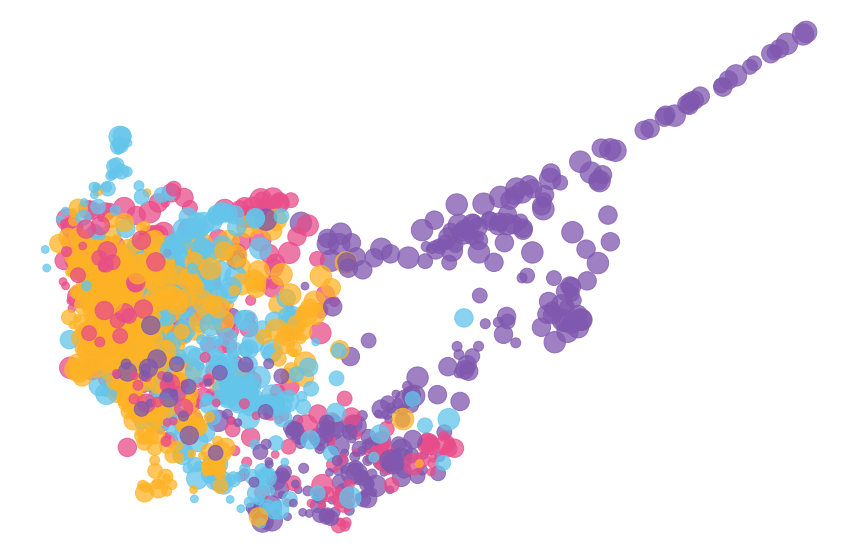

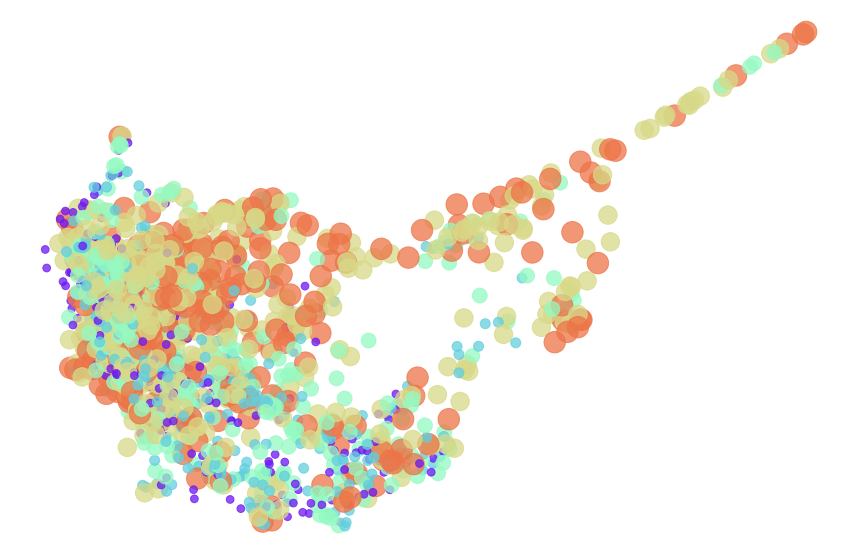

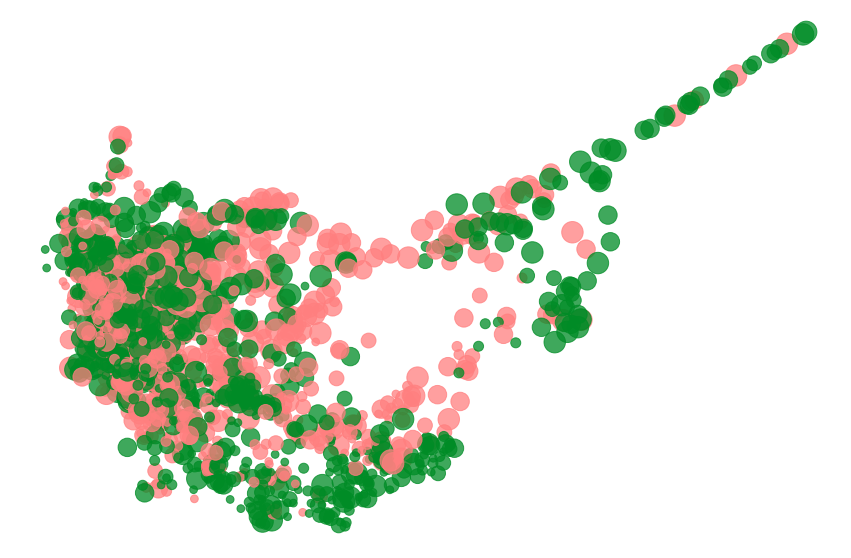

In [9]:
phate_op = phate.PHATE(
    random_state=42,
    n_jobs=-1,
    knn_dist="manhattan",
    n_pca=None,
    verbose=False,
)
phate_coords = phate_op.fit_transform(cluster_dists)
save_and_make_plot(phate_coords, embed_name)

### PhEMD (subset)
Use Phate to cluster then use distances between clusters then compute EMD between distributions over these clusters with inter-cluster distances determined by distance in the phate embedding of the mean of the cluster

In [10]:
%%time
from ot import emd2

embed_name = "PhEMD"
subset_size = 2000
data_subset = data.sample(n=subset_size, random_state=1, replace=False)

phate_op = phate.PHATE(random_state=42, n_jobs=-1, knn_dist="euclidean", verbose=False)
cell_embedding = phate_op.fit_transform(data_subset)
clusters = phate.cluster.kmeans(phate_op, k=10, random_state=42)


def cluster_emd(a, b):
    return emd2(np.ascontiguousarray(a), np.ascontiguousarray(b), M=cluster_distances)

/home/mila/a/alexander.tong/.conda/envs/pdo_screen/lib/python3.9/site-packages/phate/cluster.py:57: FutureWarning: k is deprecated. Please use n_clusters in future.
  warnings.warn(


CPU times: user 17.9 s, sys: 5.48 s, total: 23.3 s
Wall time: 9.64 s


In [11]:
# Compute inter cluster distances
metadata_subset = metadata.sample(n=subset_size, random_state=1, replace=False)
metadata_subset[[f"phate_{i}" for i in range(cell_embedding.shape[1])]] = cell_embedding
metadata_subset["phate_cluster"] = clusters
cluster_centers = metadata_subset.iloc[:, -3:].groupby("phate_cluster").mean()
cluster_distances = sklearn.metrics.pairwise.euclidean_distances(cluster_centers)

In [12]:
# Compute histogram over clusters for each sample
cluster_counts = (
    (
        metadata_subset[["Full_names", "kmeans_10_clusters", "Batch"]]
        .groupby(["Full_names", "kmeans_10_clusters"])
        .count()
    )
    .reset_index()
    .pivot(index="Full_names", columns="kmeans_10_clusters", values="Batch")
    .fillna(0)
)
cluster_dists = cluster_counts.div(cluster_counts.sum(axis=1), axis=0)

In [13]:
cluster_dists.shape

(1061, 10)

In [14]:
%%time
pairwise_emds = sklearn.metrics.pairwise.pairwise_distances(
    cluster_dists.values, metric=cluster_emd, n_jobs=1
)

CPU times: user 54.5 s, sys: 7.72 ms, total: 54.5 s
Wall time: 54.5 s


In [15]:
# Use phate on the computed EMDs to embed.
phate_op = phate.PHATE(
    random_state=42,
    n_jobs=-2,
    knn_dist="precomputed_distance",
    verbose=False,
)
phate_coords = phate_op.fit_transform(pairwise_emds)

/home/mila/a/alexander.tong/.conda/envs/pdo_screen/lib/python3.9/site-packages/graphtools/graphs.py:1035: RuntimeWarning: divide by zero encountered in divide
  pdx = (pdx.T / bandwidth).T
/home/mila/a/alexander.tong/.conda/envs/pdo_screen/lib/python3.9/site-packages/graphtools/graphs.py:1035: RuntimeWarning: invalid value encountered in divide
  pdx = (pdx.T / bandwidth).T


    Using SMACOF because SGD returned NaN


In [16]:
# Deal with unseen samples by filling NA
phate_df = (
    pd.DataFrame(phate_coords, index=cluster_dists.index)
    .join(meta["Batch"], how="outer")
    .fillna(0)
    .drop(columns="Batch")
)
assert np.all(phate_df.index == meta.index)

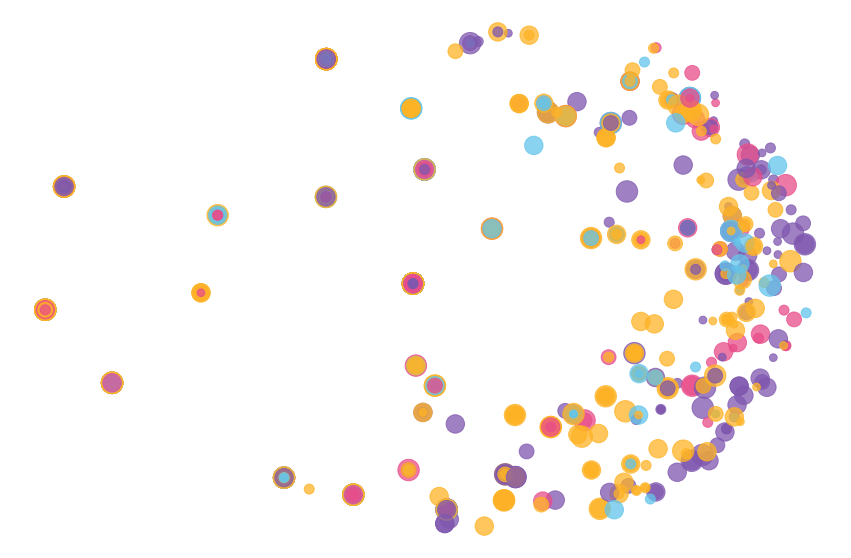

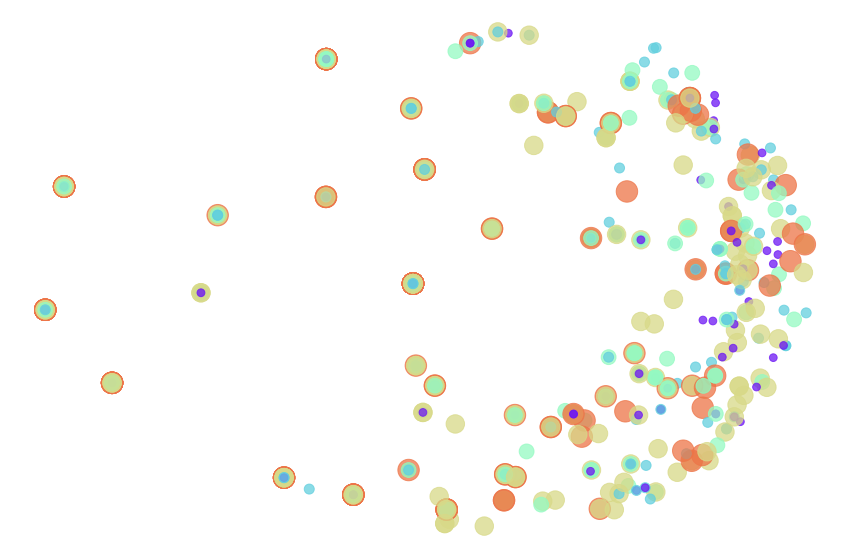

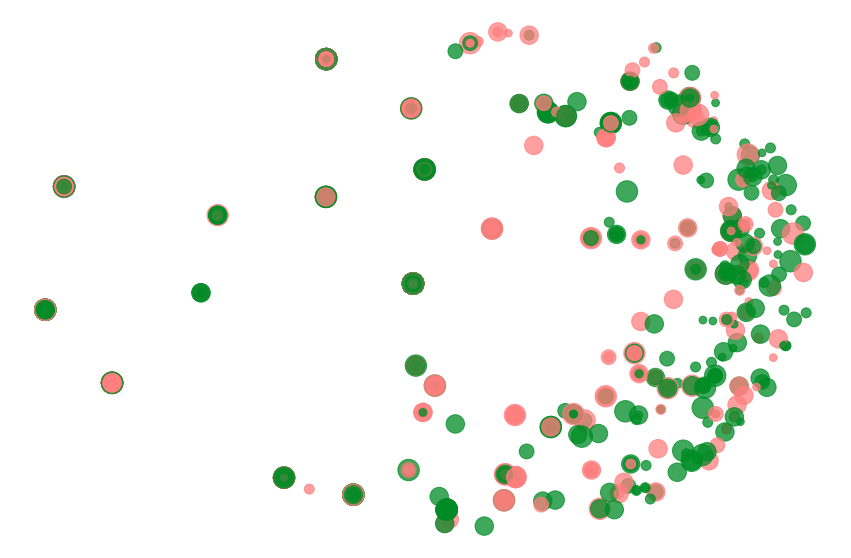

In [17]:
save_and_make_plot(phate_df.values, embed_name)

### TreeEMD

In [18]:
from MultiscaleEMD.metric_tree import MetricTreeCollection

embed_name = "TreeEMD"
# Encodes
unique, inverse = np.unique(metadata["Full_names"], return_inverse=True)
assert np.array_equal(unique, meta.index)
onehot = OneHotEncoder(sparse=True)
labels = onehot.fit_transform(inverse.reshape(-1, 1))
d = np.array(labels.sum(axis=0)).flatten()
labels_normed = labels.tocoo()
labels_normed.data = labels_normed.data / d[labels_normed.col]
labels_normed = labels_normed.tocsr()

In [19]:
%%time
mt = MetricTreeCollection(n_trees=10, tree_type="cluster", n_levels=4, n_clusters=4)
embedding = mt.fit_embed(data, labels_normed)

CPU times: user 18.5 s, sys: 334 ms, total: 18.8 s
Wall time: 5.51 s


/home/mila/a/alexander.tong/.conda/envs/pdo_screen/lib/python3.9/site-packages/graphtools/graphs.py:118: UserWarning: Building a kNNGraph on data of shape (1675, 850) is expensive. Consider setting n_pca.
  warnings.warn(


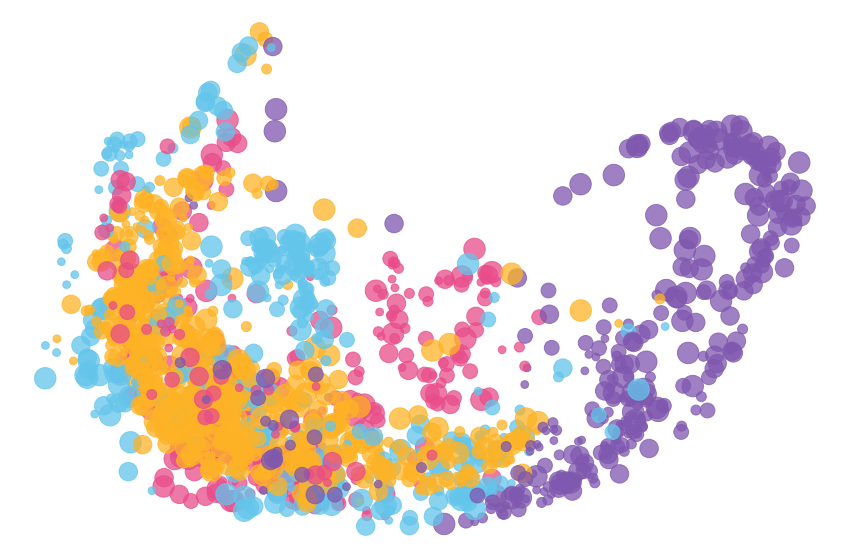

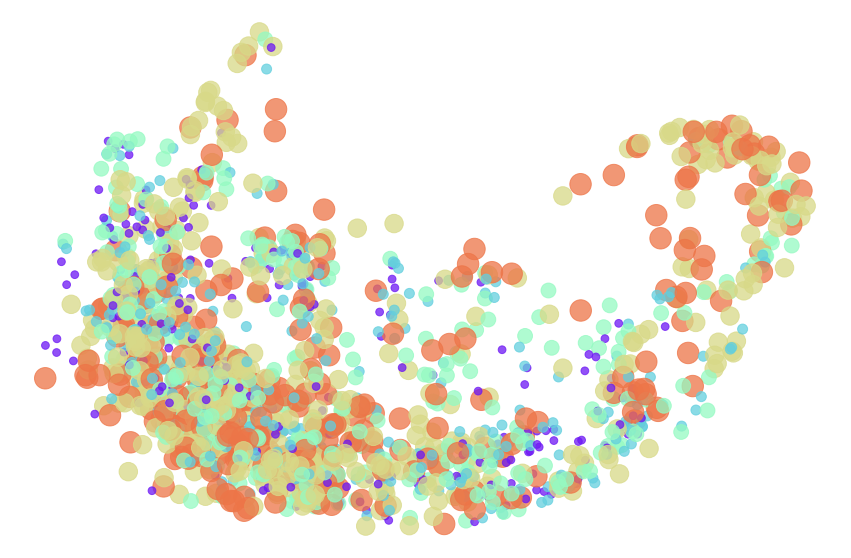

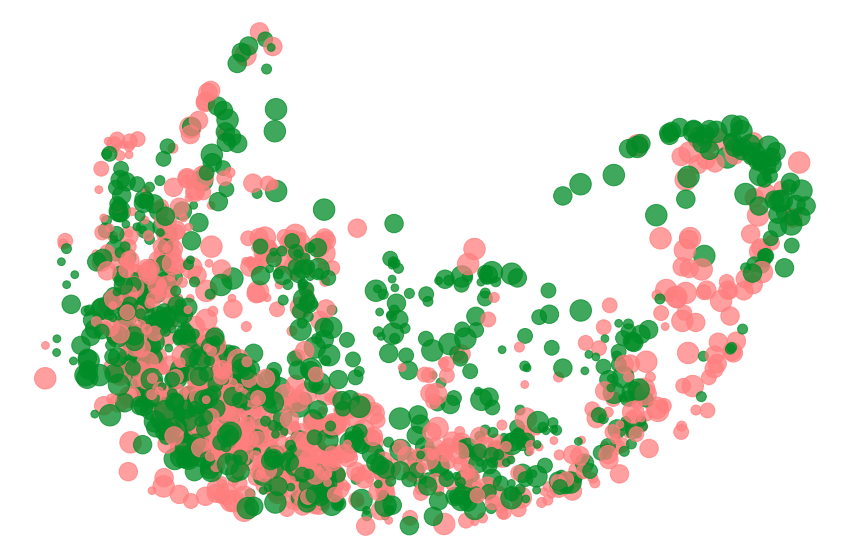

In [20]:
phate_op = phate.PHATE(
    random_state=42,
    n_jobs=-1,
    knn_dist="manhattan",
    n_pca=None,
    verbose=False,
)
phate_coords = phate_op.fit_transform(embedding)
save_and_make_plot(phate_coords, embed_name)

### Controlled TreeEMD

In [21]:
embed_name = "ControlledTreeEMD"

controlled_embedding = normalize_embedding_to_control(embedding)
np.testing.assert_array_equal(controlled_embedding.index, meta.index)

/home/mila/a/alexander.tong/.conda/envs/pdo_screen/lib/python3.9/site-packages/graphtools/graphs.py:118: UserWarning: Building a kNNGraph on data of shape (1675, 850) is expensive. Consider setting n_pca.
  warnings.warn(


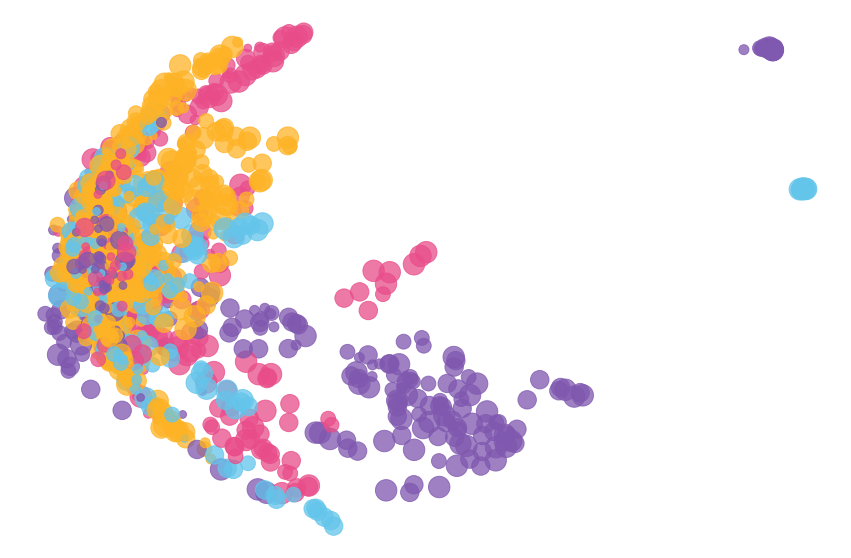

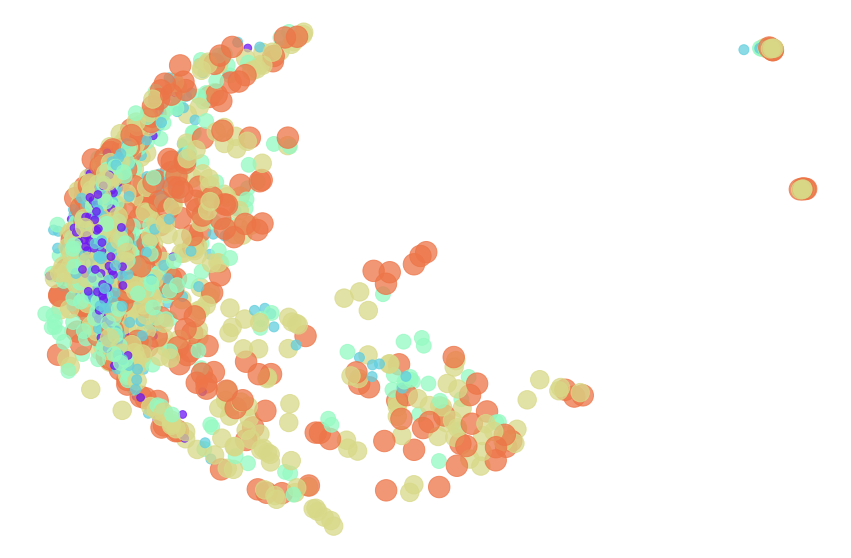

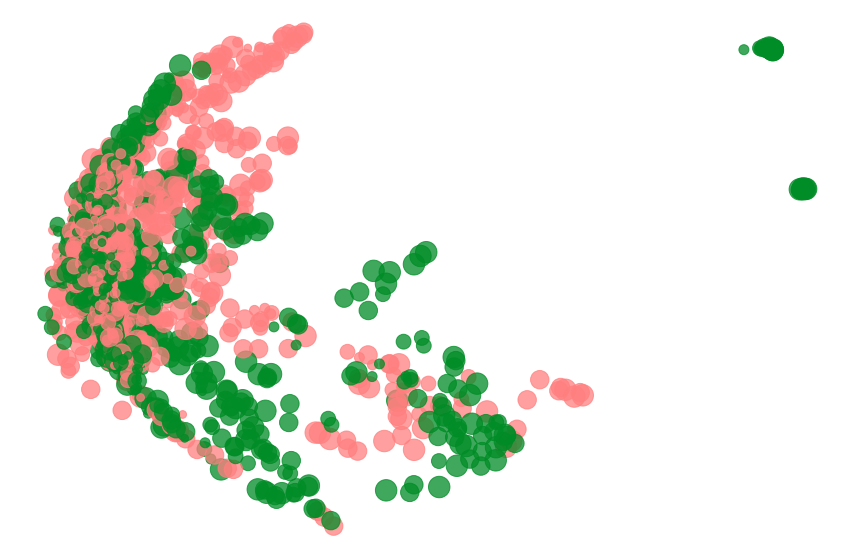

In [22]:
phate_op = phate.PHATE(
    random_state=42,
    n_jobs=-1,
    knn_dist="manhattan",
    n_pca=None,
    verbose=False,
)
phate_coords = phate_op.fit_transform(controlled_embedding)
save_and_make_plot(phate_coords, embed_name)

### Trellis

In [23]:
embed_name = "Trellis"
thresholds = {
    "pRB": -0.7,
    "IdU": 2,
    "pHH3": 2.3,
    "Cyclin_B1": -0.2,
    "cPARP": -0.8,
}
discrete = pd.concat(
    [data[gene] > thresh for gene, thresh in thresholds.items()], axis=1
)
tree = {
    "Proliferating": discrete["pRB"],
    "S_phase": discrete["pRB"] & discrete["IdU"],
    "M_phase": discrete["pRB"] & ~discrete["IdU"] & discrete["pHH3"],
    "G2_phase": discrete["pRB"]
    & ~discrete["IdU"]
    & ~discrete["pHH3"]
    & discrete["Cyclin_B1"],
    "G1_phase": discrete["pRB"]
    & ~discrete["IdU"]
    & ~discrete["pHH3"]
    & ~discrete["Cyclin_B1"],
    "Not_proliferating": ~discrete["pRB"],
    "Apoptosis": ~discrete["pRB"] & discrete["cPARP"],
    "G0_phase": ~discrete["pRB"] & ~discrete["cPARP"],
}
df_tree = pd.DataFrame(tree)
leaf_phases = ["S_phase", "M_phase", "G2_phase", "G1_phase", "G0_phase", "Apoptosis"]
cell_phase = df_tree[leaf_phases].idxmax(axis=1)

In [24]:
non_sig_markers = [
    "pHH3",
    "RFP",
    "mCHERRY",
    "Vimentin",
    "EpCAM",
    "CK18",
    "Pan_CK",
    "GFP",
    "IdU",
    "cCaspase_3",
    "Geminin",
    "pRB",
    "PLK",
    "CHGA",
    "CD90",
    "cPARP",
    "Cyclin_B1",
]
data_sig = data.drop(
    non_sig_markers,
    axis=1,
    inplace=False,
)

In [25]:
cell_phase.value_counts()

G2_phase     45075
G1_phase     18756
Apoptosis    18008
S_phase      10255
G0_phase      7368
M_phase        538
dtype: int64

In [26]:
from MultiscaleEMD.metric_tree import ManualMetricTreeCollection

mt = ManualMetricTreeCollection(
    cell_phase, n_trees=10, tree_type="cluster", n_levels=4, n_clusters=4
)
embedding = mt.fit_embed(data_sig, labels_normed)

/home/mila/a/alexander.tong/.conda/envs/pdo_screen/lib/python3.9/site-packages/graphtools/graphs.py:118: UserWarning: Building a kNNGraph on data of shape (1675, 4680) is expensive. Consider setting n_pca.
  warnings.warn(


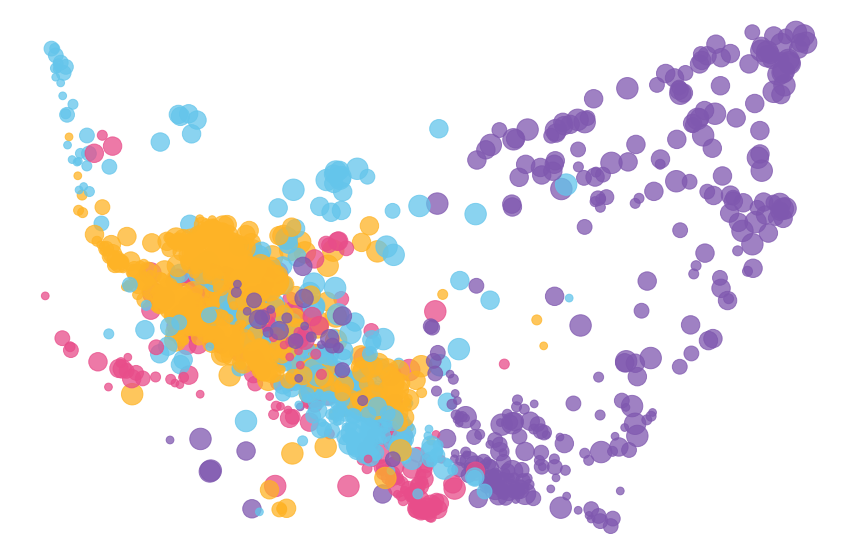

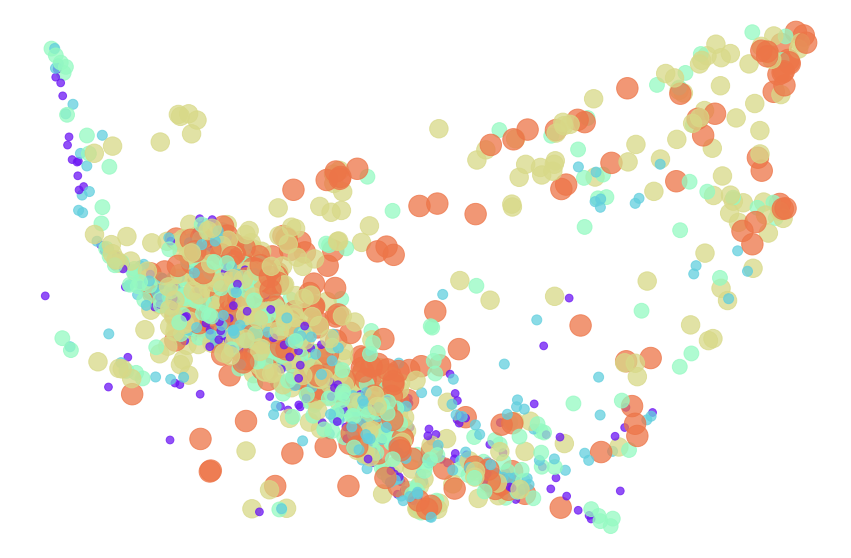

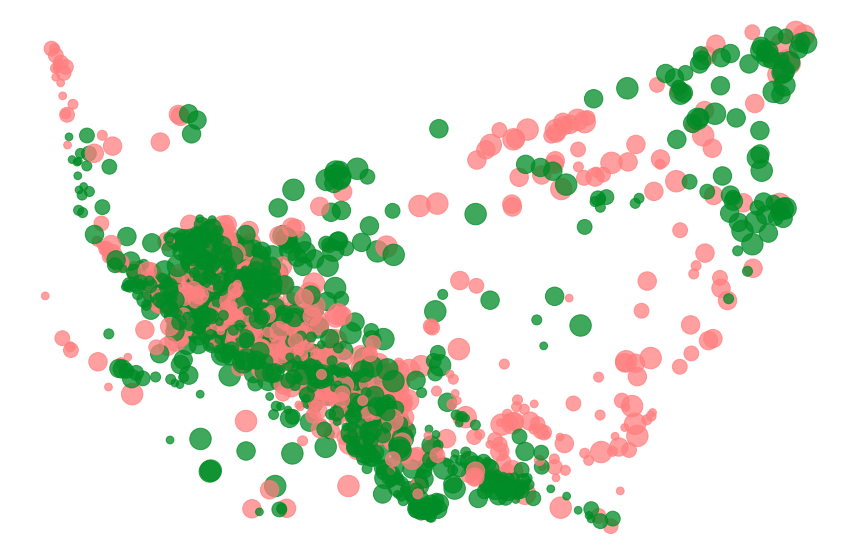

In [27]:
phate_op = phate.PHATE(
    random_state=42,
    n_jobs=-1,
    knn_dist="manhattan",
    n_pca=None,
    verbose=False,
)
phate_coords = phate_op.fit_transform(embedding)
save_and_make_plot(phate_coords, embed_name)

### ControlledTrellis

/home/mila/a/alexander.tong/.conda/envs/pdo_screen/lib/python3.9/site-packages/graphtools/graphs.py:118: UserWarning: Building a kNNGraph on data of shape (1675, 4680) is expensive. Consider setting n_pca.
  warnings.warn(


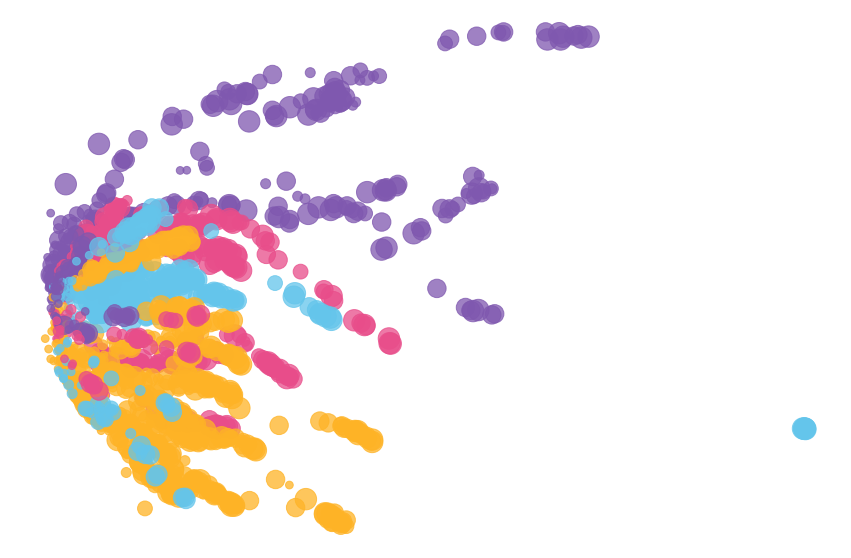

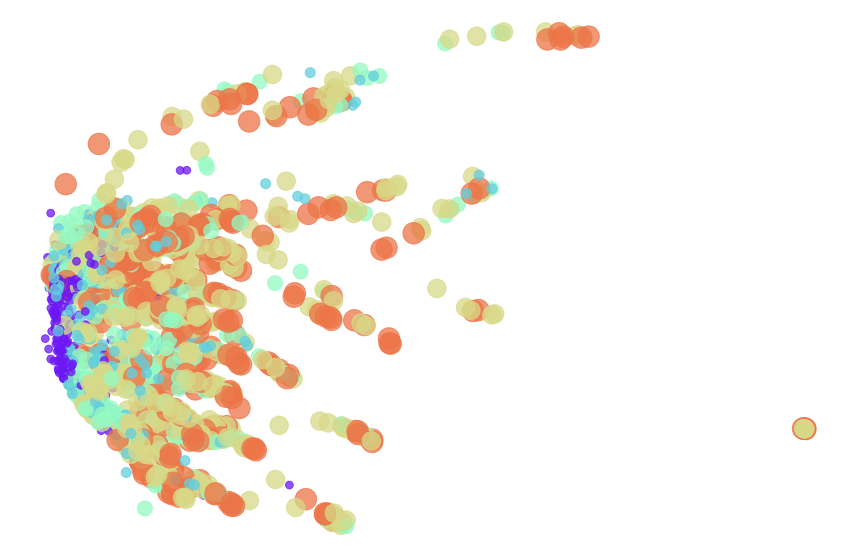

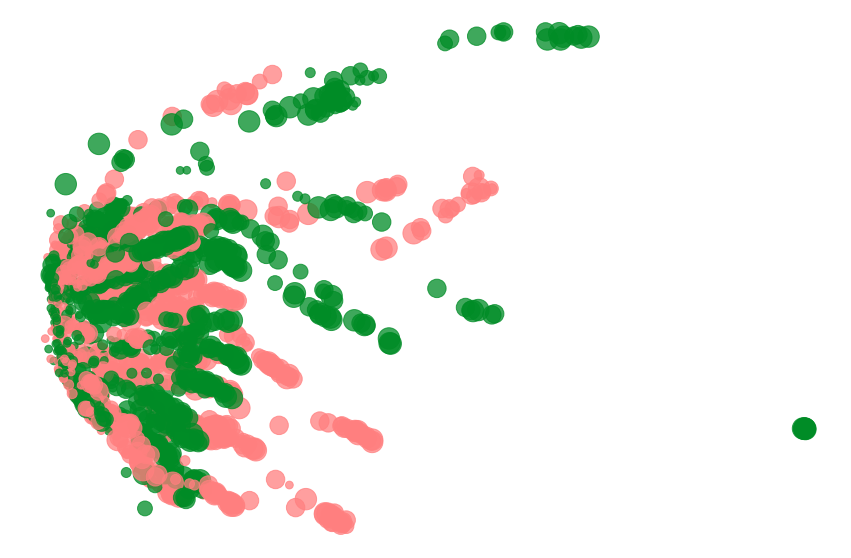

In [28]:
embed_name = "ControlledTrellis"

controlled_embedding = normalize_embedding_to_control(embedding)
np.testing.assert_array_equal(controlled_embedding.index, meta.index)
phate_op = phate.PHATE(
    random_state=42,
    n_jobs=-1,
    knn_dist="manhattan",
    n_pca=None,
    verbose=False,
)
phate_coords = phate_op.fit_transform(controlled_embedding)
save_and_make_plot(phate_coords, embed_name)

### Previous Trellis

In [29]:
def l1_embeddings(cts, edge_weights):
    return np.array(
        [np.asarray(cts)[i, :] * np.asarray(edge_weights) for i in range(len(cts))]
    )


def leaf_runner(
    data, labels, tree_type, n_trees, norm_per_subtree=False, random_state=42, **kwargs
):
    """Creates tree embeddings for each sample based on tree parameters.

    Parameters:

        data: [# cells x # features] data matrix
        labels: [# cells x # distributions] (potentially sparse) describing membership of cells to distributions
        tree_type: type of tree to build over the features
        n_trees: how many trees to build
        norm_per_subtree: whether to treat each subtree as a separate distribution,
                          this essentially weights each subtree equally, rather than weighting
                          based on how many cells are in each subtree (default)

    Returns:
        leaf_embeds: [# distributions x (n_trees x n_nodes)] embeddings one per distribution where L1 distrance
                     between embeddings represents tree EMD
        leaf_trees: Tree objects for each tree
        leaf_ids: Leaf label for each tree node [n_nodes] containing the strings of the leaf_phases
    """
    leaf_embeds = []
    leaf_counts = []
    leaf_trees = []
    leaf_ids = []
    # note that we only build a tree for each leaf phase leaving out proliferating vs. not
    rs = random_state
    for leaf in leaf_phases:
        mask = np.array(df_tree[leaf])
        sub_data = data[mask]
        sub_labels = labels[mask]
        if norm_per_subtree:
            d = np.array(sub_labels.sum(axis=0)).flatten()
            # Fix divide by zero errors
            d = np.clip(d, a_min=1e-8, a_max=None)
            sub_labels = sub_labels.tocoo()
            sub_labels.data = sub_labels.data / (d[sub_labels.col])
            sub_labels = sub_labels.tocsr()
        embeds = []
        mts = []
        all_counts = []
        for i in range(n_trees):
            mt = MetricTree(tree_type=tree_type, dense=False, random_state=rs, **kwargs)
            counts, edge_weights = mt.fit_transform(
                X=sub_data,
                y=sub_labels,
            )
            all_counts.append(counts)
            embeds.extend(l1_embeddings(counts, edge_weights).T)
            mts.append(mt)
        embeds = np.array(embeds).T
        all_counts = np.concatenate(all_counts, axis=-1)
        leaf_embeds.append(embeds)
        leaf_counts.append(all_counts)
        leaf_trees.append(mts)
        leaf_ids.append([leaf] * embeds.shape[1])
        rs += 1
    leaf_embeds = np.concatenate(leaf_embeds, axis=1)
    leaf_counts = np.array(np.concatenate(leaf_counts, axis=1))
    leaf_ids = np.concatenate(leaf_ids)
    return leaf_embeds, leaf_trees, leaf_ids, leaf_counts


def tree_runner(data, labels, tree_type, n_trees, random_state=42, **kwargs):
    """Creates tree embeddings for each sample based on tree parameters.

    This ignores known cell state structure and simply builds a tree over the entire dataset.

    Parameters:

        data: [# cells x # features] data matrix
        labels: [# cells x # distributions] (potentially sparse) describing membership of cells to distributions
        tree_type: type of tree to build over the features
        n_trees: how many trees to build
        norm_per_subtree: whether to treat each subtree as a separate distribution,
                          this essentially weights each subtree equally, rather than weighting
                          based on how many cells are in each subtree (default)

    Returns:
        leaf_embeds: [# distributions x (n_trees x n_nodes)] embeddings one per distribution where L1 distrance
                     between embeddings represents tree EMD
        leaf_trees: Tree objects for each tree
    """
    embeds = []
    mts = []
    for i in range(n_trees):
        mt = MetricTree(tree_type=tree_type, random_state=random_state + i, **kwargs)
        counts, edge_weights = mt.fit_transform(
            X=data,
            y=labels,
        )
        embeds.extend(l1_embeddings(counts, edge_weights).T)
        mts.append(mt)
    embeds = np.array(embeds).T
    return embeds, mts

/home/mila/a/alexander.tong/.conda/envs/pdo_screen/lib/python3.9/site-packages/graphtools/graphs.py:118: UserWarning: Building a kNNGraph on data of shape (1675, 4700) is expensive. Consider setting n_pca.
  warnings.warn(
/home/mila/a/alexander.tong/.conda/envs/pdo_screen/lib/python3.9/site-packages/graphtools/graphs.py:280: RuntimeWarning: Detected zero distance between samples 517 and 612. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


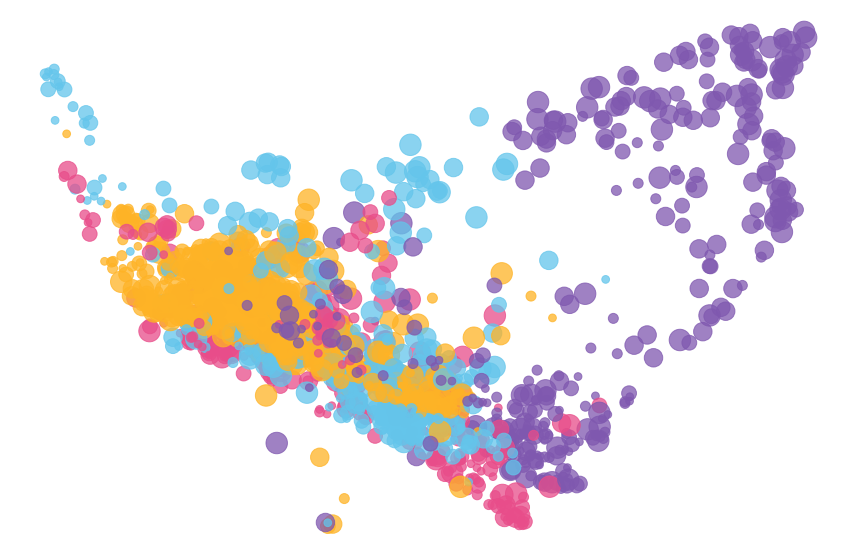

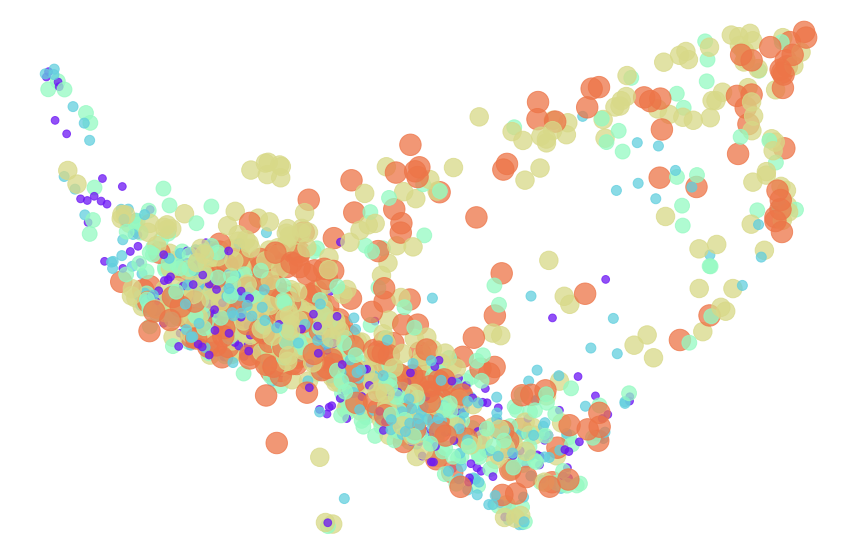

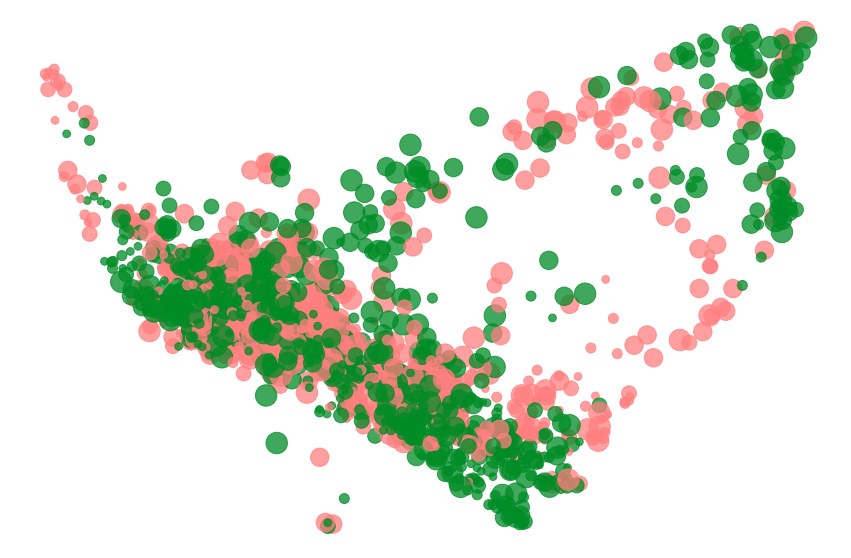

In [30]:
embed_name = "OldTrellis"

runs = {
    "nonorm": leaf_runner(
        data_sig.values,
        labels_normed,
        "cluster",
        10,
        norm_per_subtree=False,
        n_levels=4,
        n_clusters=4,
    ),
    # Without cell state splitting, a tree built from the top
    "full_tree_all": tree_runner(
        data.values, labels_normed, "cluster", 1, n_levels=4, n_clusters=4
    ),
}

embedding = runs["nonorm"][0]

phate_op = phate.PHATE(
    random_state=42,
    n_jobs=-1,
    knn_dist="manhattan",
    n_pca=None,
    verbose=False,
)
phate_coords = phate_op.fit_transform(embedding)
save_and_make_plot(phate_coords, embed_name)

/home/mila/a/alexander.tong/.conda/envs/pdo_screen/lib/python3.9/site-packages/graphtools/graphs.py:118: UserWarning: Building a kNNGraph on data of shape (1675, 4700) is expensive. Consider setting n_pca.
  warnings.warn(


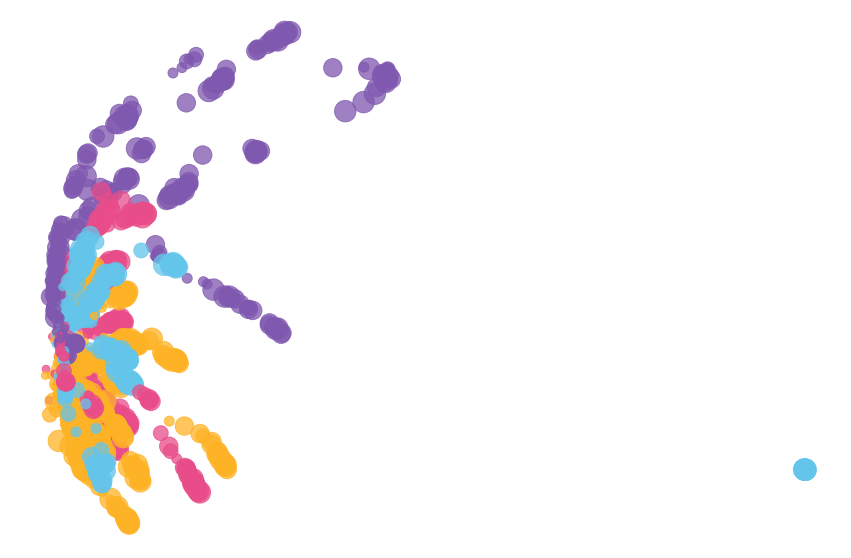

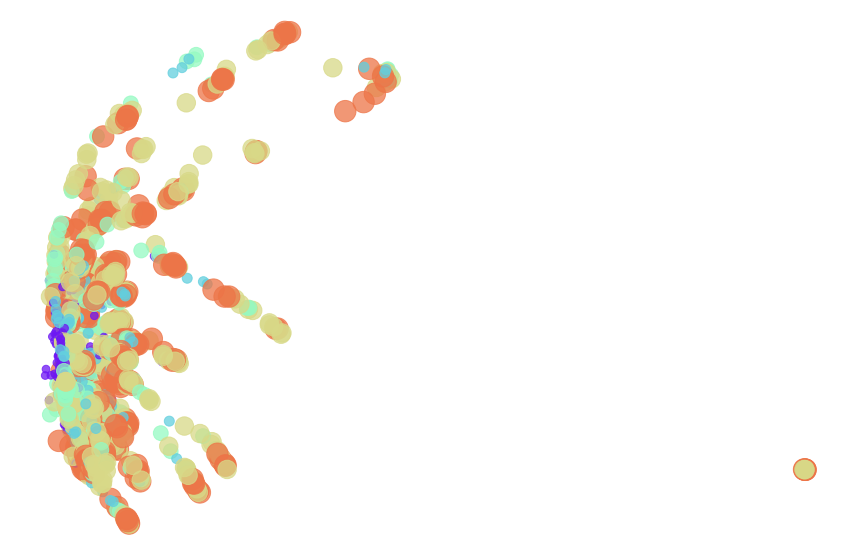

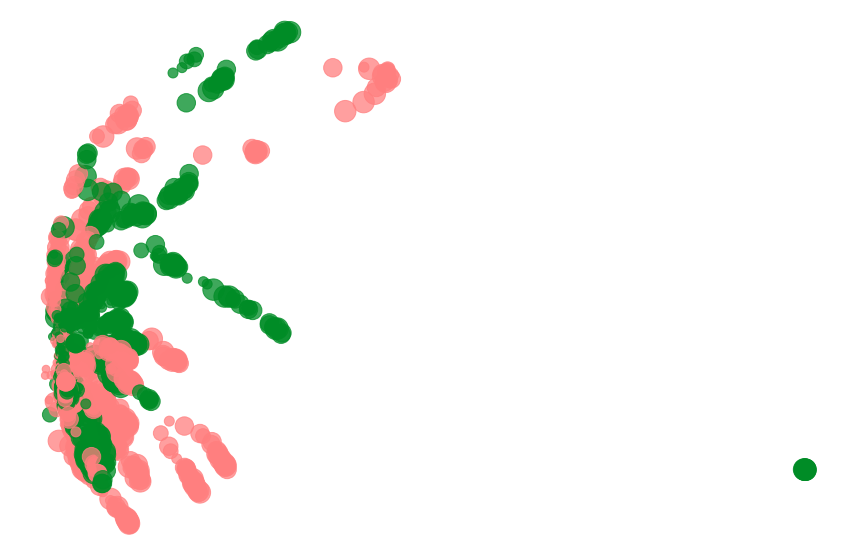

In [31]:
embed_name = "OldControlledTrellis"

controlled_embedding = normalize_embedding_to_control(embedding)
np.testing.assert_array_equal(controlled_embedding.index, meta.index)

phate_op = phate.PHATE(
    random_state=42,
    n_jobs=-1,
    knn_dist="manhattan",
    n_pca=None,
    verbose=False,
)
phate_coords = phate_op.fit_transform(controlled_embedding)
save_and_make_plot(phate_coords, embed_name)

/home/mila/a/alexander.tong/.conda/envs/pdo_screen/lib/python3.9/site-packages/graphtools/graphs.py:280: RuntimeWarning: Detected zero distance between samples 686 and 874. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


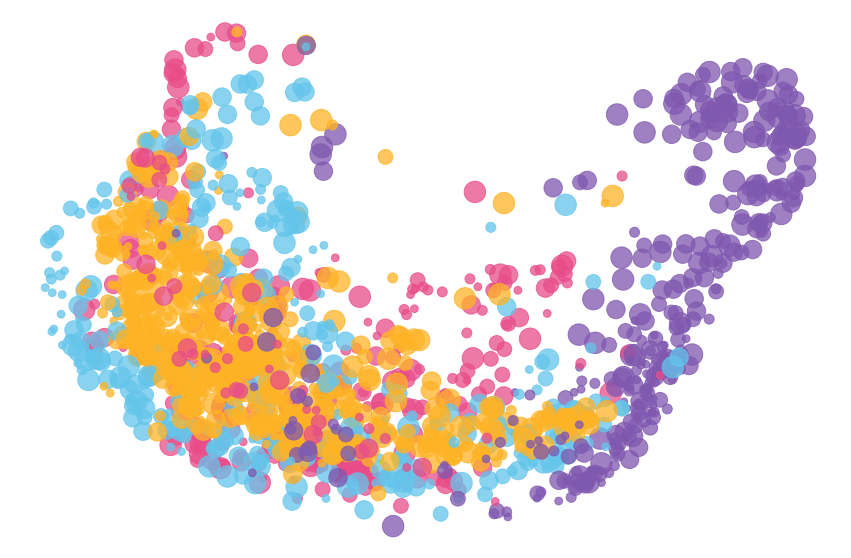

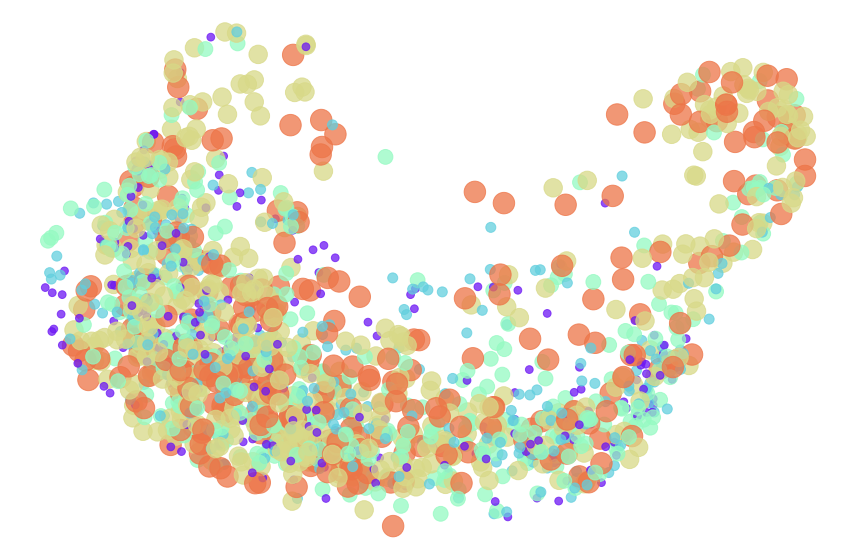

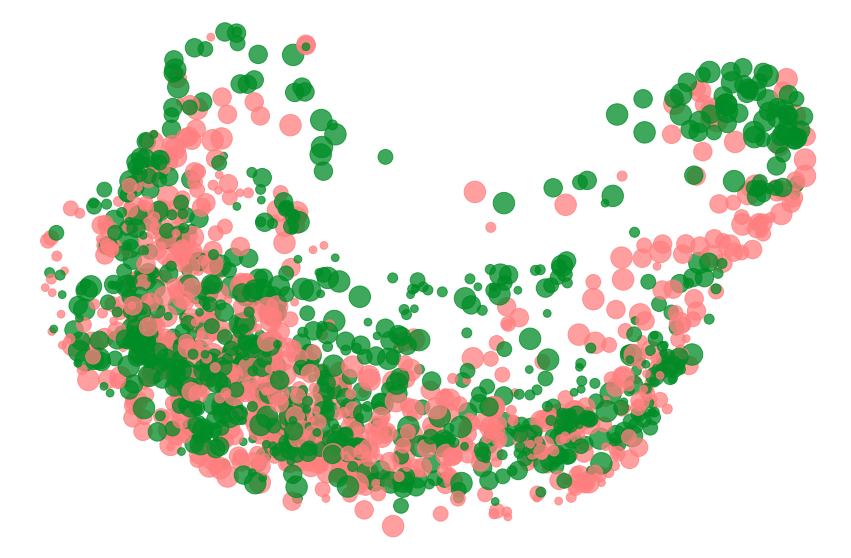

In [32]:
embed_name = "OldTreeEMD"

embedding = runs["full_tree_all"][0]

phate_op = phate.PHATE(
    random_state=42,
    n_jobs=-1,
    knn_dist="manhattan",
    n_pca=None,
    verbose=False,
)
phate_coords = phate_op.fit_transform(embedding)
save_and_make_plot(phate_coords, embed_name)

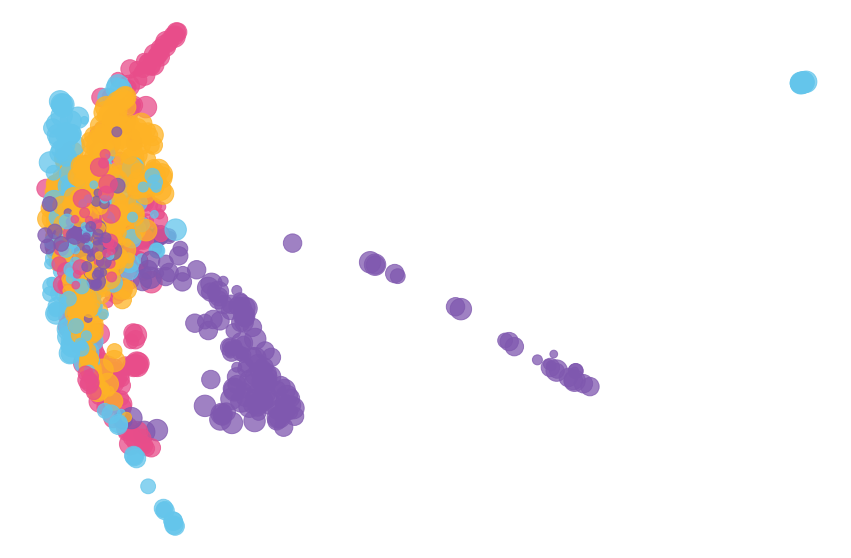

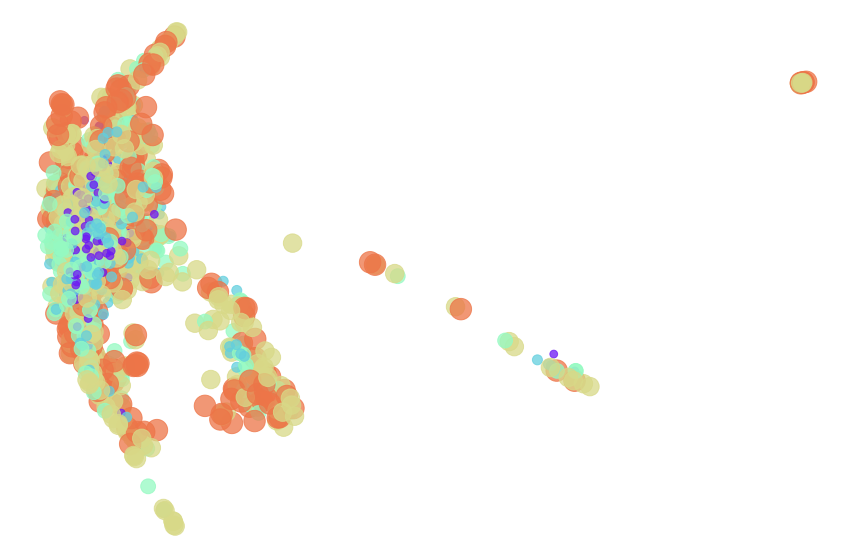

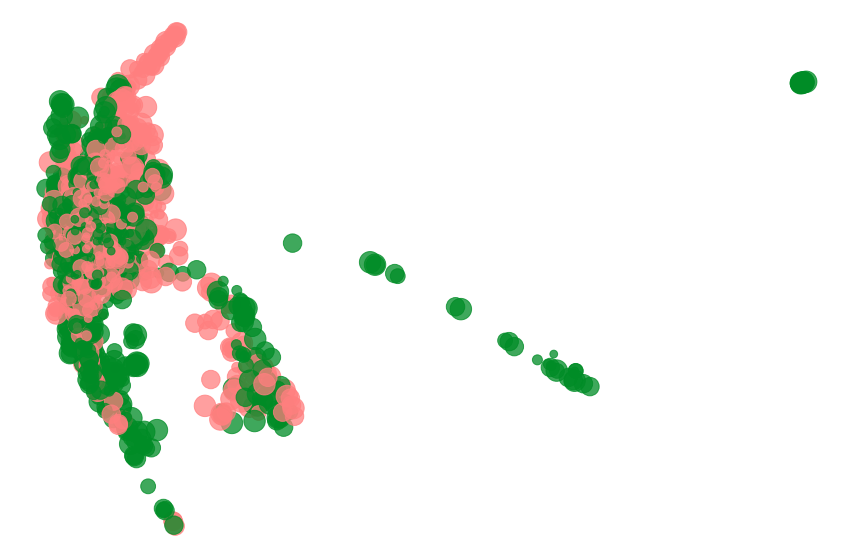

In [33]:
embed_name = "OldControlledTreeEMD"

controlled_embedding = normalize_embedding_to_control(embedding)
np.testing.assert_array_equal(controlled_embedding.index, meta.index)

phate_op = phate.PHATE(
    random_state=42,
    n_jobs=-1,
    knn_dist="manhattan",
    n_pca=None,
    verbose=False,
)
phate_coords = phate_op.fit_transform(controlled_embedding)
save_and_make_plot(phate_coords, embed_name)